# Chapter 5: Generalized Linear Models: Completion % over Expected

In [2]:
## load packages
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Change theme for chapter
sns.set_theme(style="whitegrid", palette="colorblind")


In [3]:
from loader import get_pbp

pbp_py = get_pbp(range(2016, 2022 + 1))

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [4]:
pbp_py_pass = pbp_py.query(
    'play_type == "pass" & passer_id.notnull() &' + "air_yards.notnull()"
).reset_index()


Next, restrict air yards to be greater than 0 yards and less than or equal to 20 yards in order to ensure that you have a large enough sample size. Summarize the data to calculate the completion percentage, comp_pct. Then plot results to create Figure 5-1:

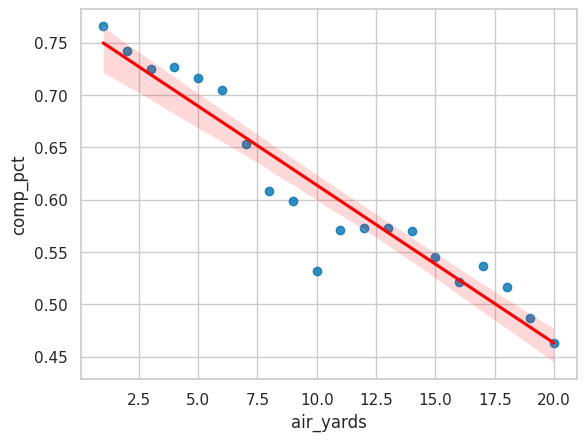

In [5]:
# Filter more and then plot
pass_pct_py = (
    pbp_py_pass.query("0 < air_yards <= 20")
    .groupby("air_yards")
    .agg({"complete_pass": ["mean"]})
)

pass_pct_py.columns = list(map("_".join, pass_pct_py.columns))

pass_pct_py.reset_index(inplace=True)
pass_pct_py.rename(columns={"complete_pass_mean": "comp_pct"}, inplace=True)

sns.regplot(data=pass_pct_py, x="air_yards", y="comp_pct", line_kws={"color": "red"})
plt.show()

Completion percentage over expected, referred to as CPOE in the football analytics world (and introduced in Chapter 1), is one of the adjusted metrics that has made its way into the mainstream. 

Measuring quarterback performance this way has some issues, which we will touch on at the end of the chapter, but CPOE is here to stay. We will start the process of walking you through its development by using generalized linear models.

# Generalized Linear Models
GLMs generalize, or extend, linear models to allow for response variables that are assumed to come from a non-normal distribution (such as binary responses or counts). The specific type of response distribution is called the family


In contrast, a binomial distribution requires only one parameter: a probability of success. With the pass example, this would be the probability of completing a pass. However, statistically modeling probability is hard because it is bounded by 0 and 1. So, a link function converts (or links) probability (a value ranging from 0 to 1) to a value ranging from  to . The most common link function is the logit, which gives a name to one of the most common types of GLMs, the logistic regression.

In [8]:
## building a glm
complete_ay_py = smf.glm(
    formula="complete_pass ~ air_yards", data=pbp_py_pass, family=sm.families.Binomial()
).fit()
complete_ay_py.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          complete_pass   No. Observations:               131609
Model:                            GLM   Df Residuals:                   131607
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -81066.
Date:                Thu, 30 Oct 2025   Deviance:                   1.6213e+05
Time:                        08:19:54   Pearson chi2:                 1.32e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.07025
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0727      0.008    133.352      0.000       1.057       1.089
air_yards     -0.0574      0.001    -91.882      0.000      -0.059      -0.056
==============================================================================
"""

To help you see the results from logistic regressions, both Python and R have plotting tools. With Python, use regplot() from seaborn, but set the logistic option to True to create Figure 5-3 (to see why a linear regression is a bad idea for this model, use the default option of False and notice how the line goes above and below the data):

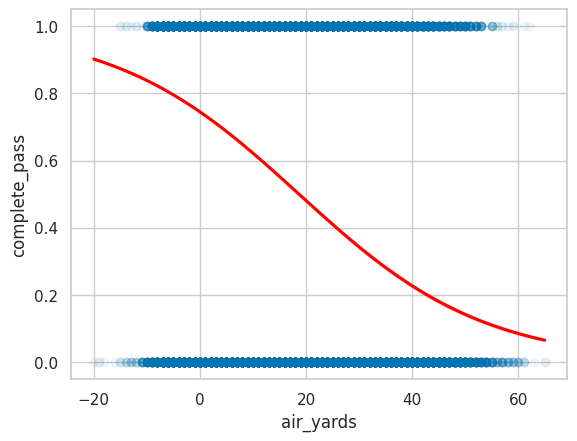

In [9]:
## logistic plot
sns.regplot(
    data=pbp_py_pass,
    x="air_yards",
    y="complete_pass",
    logistic=True,
    line_kws={"color": "red"},
    scatter_kws={"alpha": 0.05},
)
plt.show()

In this plot, the curved line is the logistic function. 
The semitransparent points are the binary outcome for completed passes. 
Because of the large number of overlapping points, the logistic line is necessary to see any trends in the data.

In [10]:
## glm completion percentage predicted
pbp_py_pass["exp_completion"] = complete_ay_py.predict()
pbp_py_pass["cpoe"] = pbp_py_pass["complete_pass"] - pbp_py_pass["exp_completion"]

## cpoe
cpoe_py = pbp_py_pass.groupby(["season", "passer_id", "passer"]).agg(
    {"cpoe": ["count", "mean"], "complete_pass": ["mean"]}
)
cpoe_py.columns = list(map("_".join, cpoe_py.columns))
cpoe_py.reset_index(inplace=True)
cpoe_py = cpoe_py.rename(
    columns={"cpoe_count": "n", "cpoe_mean": "cpoe", "complete_pass_mean": "compl"}
).query("n > 100")
print(cpoe_py.sort_values("cpoe", ascending=False))

     season   passer_id      passer    n      cpoe     compl
299    2019  00-0020531     D.Brees  406  0.094040  0.756158
193    2018  00-0020531     D.Brees  566  0.086427  0.738516
467    2020  00-0033537    D.Watson  542  0.073530  0.704797
465    2020  00-0033357      T.Hill  121  0.072455  0.727273
22     2016  00-0026143      M.Ryan  631  0.068902  0.702060
..      ...         ...         ...  ...       ...       ...
91     2016  00-0033106      J.Goff  204 -0.108796  0.549020
526    2021  00-0027939    C.Newton  126 -0.109966  0.547619
112    2017  00-0025430   D.Stanton  159 -0.110233  0.496855
730    2022  00-0037327  S.Thompson  150 -0.116848  0.520000
163    2017  00-0031568     B.Petty  112 -0.151896  0.491071

[300 rows x 6 columns]


In [11]:
## remove missing data and format data
pbp_py_pass["down"] = pbp_py_pass["down"].astype(str)
pbp_py_pass["qb_hit"] = pbp_py_pass["qb_hit"].astype(str)
pbp_py_pass_no_miss = pbp_py_pass[
    [
        "passer",
        "passer_id",
        "season",
        "down",
        "qb_hit",
        "complete_pass",
        "ydstogo",
        "yardline_100",
        "air_yards",
        "pass_location",
    ]
].dropna(axis=0)


In [12]:
## build and fit model
complete_more_py = smf.glm(
    formula="complete_pass ~ down * ydstogo + "
    + "yardline_100 + air_yards + "
    + "pass_location + qb_hit",
    data=pbp_py_pass_no_miss,
    family=sm.families.Binomial(),
).fit()

In [13]:
## extract output and calculate CPOE
pbp_py_pass_no_miss["exp_completion"] = complete_more_py.predict()
pbp_py_pass_no_miss["cpoe"] = (
    pbp_py_pass_no_miss["complete_pass"] - pbp_py_pass_no_miss["exp_completion"]
)

## summarize outputs, reformat, and rename
cpoe_py_more = pbp_py_pass_no_miss.groupby(["season", "passer_id", "passer"]).agg(
    {"cpoe": ["count", "mean"], "complete_pass": ["mean"], "exp_completion": ["mean"]}
)

cpoe_py_more.columns = list(map("_".join, cpoe_py_more.columns))
cpoe_py_more.reset_index(inplace=True)

cpoe_py_more = cpoe_py_more.rename(
    columns={
        "cpoe_count": "n",
        "cpoe_mean": "cpoe",
        "complete_pass_mean": "compl",
        "exp_completion_mean": "exp_completion",
    }
).query("n > 100")

## print outputs
print(cpoe_py_more.sort_values("cpoe", ascending=False))


     season   passer_id    passer    n      cpoe     compl  exp_completion
193    2018  00-0020531   D.Brees  566  0.088881  0.738516        0.649635
299    2019  00-0020531   D.Brees  406  0.087838  0.756158        0.668320
465    2020  00-0033357    T.Hill  121  0.082913  0.727273        0.644360
22     2016  00-0026143    M.Ryan  631  0.077523  0.702060        0.624538
467    2020  00-0033537  D.Watson  542  0.072845  0.704797        0.631953
..      ...         ...       ...  ...       ...       ...             ...
631    2021  00-0037013  Z.Wilson  382 -0.100534  0.557592        0.658126
506    2020  00-0036312   J.Luton  110 -0.106424  0.545455        0.651879
91     2016  00-0033106    J.Goff  204 -0.112446  0.549020        0.661465
526    2021  00-0027939  C.Newton  126 -0.123308  0.547619        0.670927
163    2017  00-0031568   B.Petty  112 -0.166772  0.491071        0.657844

[300 rows x 7 columns]


In [14]:
## stability
#  keep only the columns needed
cols_keep = ["season", "passer_id", "passer", "cpoe", "compl", "exp_completion"]

# create current dataframe
cpoe_now_py = cpoe_py_more[cols_keep].copy()

# create last-year's dataframe
cpoe_last_py = cpoe_now_py[cols_keep].copy()

# rename columns
cpoe_last_py.rename(
    columns={
        "cpoe": "cpoe_last",
        "compl": "compl_last",
        "exp_completion": "exp_completion_last",
    },
    inplace=True,
)
# add 1 to season
cpoe_last_py["season"] += 1

# merge together
cpoe_lag_py = cpoe_now_py.merge(
    cpoe_last_py, how="inner", on=["passer_id", "passer", "season"]
)


In [15]:
## look at pass completion stability
cpoe_lag_py[["compl_last", "compl"]].corr()

,compl_last,compl
compl_last,1.000000,0.445931
compl,0.445931,1.000000


In [16]:

## look at cpoe stability
cpoe_lag_py[["cpoe_last", "cpoe"]].corr()

,cpoe_last,cpoe
cpoe_last,1.000000,0.465809
cpoe,0.465809,1.000000
